# Disurption Index

※　ソースコードは順番に実行しないと正常に機能しない恐れがあります

## 概要

Disruption Index [Disruptiveness, Disruptive Index, D-indexとも呼ばれる。以下D-index] は、[Funk and Owen-Smith (2017)]らによって経営工学で提唱されたものを[Wu et al. 2019]が科学計量学に持ち込んだもので、革新性を「ある論文がそれ以前の文脈と断絶する度合い」と考え、断絶性を引用によって測った指標。

論文と特許について分析し、「すべての分野にわたって平均破壊スコアが継続的に低下している」と報告した[Park et al. 2023]の論文は特に科学システムの内外に波紋を広げ、ここ数十年における（世界的な）科学システムの大幅な拡大にも関わらず、科学が勢いを失っているのかどうか、そしてなぜそのような問題を巡る世間の議論を引き起こすなど、D-indexに関する議論は社会的にも大きな関心を呼んだ。さらに多数の改良指標が提案されている。

一方で、時系列比較に意味がないなど複数の留意点があることが近年の分析[C. Leibel & L. Bornamnn 2023]からわかっており、使用する際には対象とするデータの特性や分析の目的に照らし合わせて、D-indexを使用することが適切か注意が必要である。


## なぜDisruption Indexを考えるのか

革新性を評価する多くの指標と同様に、DIは研究の重要度を測るために活用できる可能性を持った指標である。

### 政策への影響

研究は大きく漸進的(Incremental)研究と、革新的(Disruptive)研究があるとされており、漸進的研究に対しては計画が立てやすく、予算をつけ易い。一方で研究資金の配分を決定する際には革新的研究を適切に評価することで、新たな分野を開拓するような研究を捉えられれば研究競争力を大きく伸ばす可能性がある。

## Disruption Index関連での重要論文

What do we know about the disruption index in scientometrics? An overview of the literature

A review of the literature on citation impact indicators


## Disruption Indexの定義

![D definition](./supplementary/D_def.png)
![D example](./supplementary/D_example.png)

[Lingfei Wu et al. 2019]


In [1]:
%pip install pyalex

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

DATA_DIR = '/disks/qnap2/data/t-yatima/scisciJP2024_tutorial/'
INPUT_WORKS_DF_PKL = DATA_DIR + 'random_works_df.pkl'
INPUT_CITATIONS_DF_PKL = DATA_DIR + 'random_rel_ref_df.pkl'
# INPUT_CITATIONS_GB_DF_PKL = DATA_DIR + 'citations_gb_df.pkl'
INPUT_WU_WORKS_LIST_PKL = DATA_DIR + 'teamsize_impact_disrup_refAge_refPop.pkl'

In [ ]:
# colabで実行する時のためのコード
import sys
import os

%cd /content/sample_data/
!git clone https://github.com/ScisciJP/scisciJP2024_tutorial.git
%cd /content/sample_data/scisciJP2024_tutorial/supplementary/
!wget https://storage.googleapis.com/scisijp2024test/supplementary/teamsize_impact_disrup_refAge_refPop.pkl
!wget https://storage.googleapis.com/scisijp2024test/supplementary/random_rel_ref_df.pkl

sys.path.append('/content/sample_data/scisciJP2024_tutorial')
print(os.getcwd())
os.chdir('/content/sample_data/scisciJP2024_tutorial')
sys.path

DATA_DIR = '/content/sample_data/scisciJP2024_tutorial/supplementary/'
INPUT_WORKS_DF_PKL = DATA_DIR + 'random_works_df.pkl'
INPUT_CITATIONS_DF_PKL = DATA_DIR + 'random_rel_ref_df.pkl'
# INPUT_CITATIONS_GB_DF_PKL = DATA_DIR + 'citations_gb_df.pkl'
INPUT_WU_WORKS_LIST_PKL = DATA_DIR + 'teamsize_impact_disrup_refAge_refPop.pkl'

In [4]:
works_df = pd.read_pickle(INPUT_WORKS_DF_PKL)
citations_df = pd.read_pickle(INPUT_CITATIONS_DF_PKL)
W = pickle.load(open(INPUT_WU_WORKS_LIST_PKL, 'rb')) 
display(works_df[:5], len(works_df), citations_df[:5], len(citations_df), W[:5], len(W))

,JournalId,Year,NumberCitations,Title,Date,DocType,Doi,PMID,Volume,Issue,FirstPage,LastPage,IsRetracted,IsParaText,AuthorCount
PublicationId,,,,,,,,,,,,,,,
2242094754,NaN,2005,0,Understanding what child protection data mean:...,2005-08-11,article,NaN,NaN,NaN,NaN,NaN,NaN,False,False,2.0
2951317825,NaN,2015,0,Desvendando o Universo com o Céu da Serra Gaúcha,2015-11-30,article,NaN,NaN,3,3,NaN,NaN,False,False,4.0
3030572269,NaN,2018,0,The estrogen deficiency hypothesis of schizoph...,2018-12-05,article,10.3760/cma.j.issn.1006-7884.2018.06.010,NaN,51,6,385,388,False,False,1.0
353247501,NaN,1977,0,"金大中氏拉致事件(ドキュメント)--コリアゲ-トの決壊〔含 日誌,解説〕",1977-02-01,article,NaN,NaN,NaN,375,206,227,False,False,1.0
423748994,NaN,1957,0,フランス法におけるfonds de commerce(営業)について,1957-07-01,article,NaN,NaN,2,1,73,108,False,False,1.0


45535

,source,target
0,2147314816,2147486095
1,2604406667,2267581838
2,4387491849,2045680610
3,4387749131,3112902030
4,4387747277,2619010848


97002308

[[1, 3, 0.0045662100456621, 2.12195121951, 8.5],
 [2, 5, -0.0005822981366459627, 2.45911949686, 17.0],
 [1, 3, -0.00023282887077997672, 1.74468085106, 17.0],
 [1, 2, -0.0007238508867173362, 3.33870967742, 23.0],
 [1, 1, -0.0007763975155279503, 2.74193548387, 18.5]]

24174022

## ネットワークの可視化


In [5]:
import time
from pyalex import Works
import random
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

related_ref_df = citations_df

def get_nodetypes(c,  s, t):
    nodes_b = set(c) & set(s) 
    nodes_f = set(c) - set(s)
    nodes_r = set(s) - set(c) - set(t)
    return nodes_b, nodes_f, nodes_r

def draw_network(ID):
    works_target = related_ref_df[related_ref_df["source"]==ID]
    works_source = related_ref_df[related_ref_df["target"].isin(works_target["target"].values)]
    works_citing = related_ref_df[related_ref_df["target"]==ID]

    edges = [tuple(row) for _, row in works_source[["source","target"]].iterrows()] + [tuple(row) for _, row in works_citing[["source","target"]].iterrows()]
    nodes = set([item for sublist in edges for item in sublist])

    node_detail = None
    for id in nodes:
        node_detail = pd.concat([node_detail,pd.DataFrame(Works().filter(ids={"openalex":"W"+str(id)}).select(["title","publication_date"]).get(), index=[id])])
    node_detail = node_detail.fillna(value={"title": "No title"})

    node_detail["unix_time"] = node_detail["publication_date"].apply(lambda t: int(time.mktime(time.strptime(t, "%Y-%m-%d"))))
    node_detail["date_diff"] = node_detail["unix_time"] - node_detail.loc[ID, "unix_time"]

    nodes_b, nodes_f, nodes_r = get_nodetypes(works_citing["source"].unique(), works_source["source"].unique(),works_target["target"].unique())

    node_detail.loc[list(nodes_b), "type"] = 1
    node_detail.loc[list(nodes_f), "type"] = 2 
    node_detail.loc[list(nodes_r), "type"] = 3
    node_detail = node_detail.fillna({"type": -1})

    node_detail.loc[ID, "type"] = 0

    color = ["black", "red","green","gold","grey"]
    node_detail["color"] = node_detail["type"].apply(lambda x: color[int(x)])
    node_detail["ypos"] = -(node_detail["type"]-2)*15+np.array([(random.random()-0.5)*50 for _ in range(len(node_detail))])
    node_detail.loc[ID, "ypos"] = 0
    node_detail["xpos"] = node_detail["date_diff"]/10000000 +50*np.sign(node_detail["type"])
    node_detail.loc[ID, "xpos"] = 0
    node_detail["size"] = 50
    node_detail.loc[ID, "size"] = 100

    G = nx.DiGraph()

    G.add_edges_from(edges)
    nodes_pos = {v:(node_detail.loc[v,"xpos"],node_detail.loc[v,"ypos"]) for v in node_detail.index}
    max_length = 25  # Maximum length of the title
    node_labels = {node: node_detail.loc[node, 'title'][:max_length] + "..." if len(node_detail.loc[node, 'title']) > max_length else node_detail.loc[node, 'title'] for node in G.nodes()}
    label_pos = {v:(node_detail.loc[v,"xpos"],node_detail.loc[v,"ypos"]-2) for v in node_detail.index}

    node_colors = [node_detail.loc[node,'color'] for node in G.nodes()]
    node_sizes = [node_detail.loc[node,'size'] for node in G.nodes()]

    nx.draw_networkx_edges(G,nodes_pos, arrows=True,node_size=2, connectionstyle="arc3, rad=0.2", arrowstyle="->", alpha= 0.3, arrowsize=27)
    nx.draw_networkx_labels(G, pos=label_pos, labels=node_labels, font_size=9, alpha=0.5)
    nx.draw_networkx_nodes(G, nodes_pos, node_size=node_sizes, node_shape='o',edgecolors=node_colors,node_color="white",linewidths=2, alpha= 1)
    plt.tight_layout()
    plt.show()
    plt.close()
    display(node_detail.sort_values(by="type"))

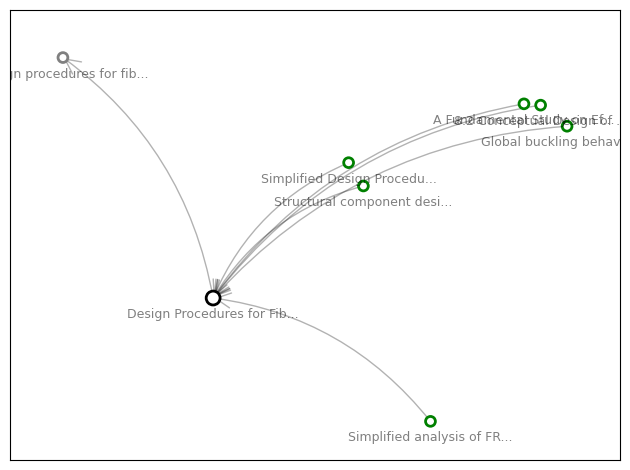

,title,publication_date,unix_time,date_diff,type,color,ypos,xpos,size
243095882,Design procedures for fiber composite structur...,1985-01-01,473353200,-141868800,-1.0,grey,28.903393,-64.18688,50
1982793646,Design Procedures for Fiber Composite Box Beams,1989-07-01,615222000,0,0.0,black,0.000000,0.00000,100
45747392,Simplified Design Procedures for Fiber Composi...,1992-01-01,694191600,78969600,2.0,green,16.271034,57.89696,50
3145202368,Global buckling behavior of blade stiffened co...,2021-08-01,1627743600,1012521600,2.0,green,20.648097,151.25216,50
2279102757,Structural component design techniques,1994-01-01,757350000,142128000,2.0,green,13.469591,64.21280,50
2144429227,Simplified analysis of FRP box-girders,2003-02-01,1044025200,428803200,2.0,green,-14.823571,92.88032,50
2611572116,8.2 Conceptual Design of Composite Structures,2018-01-01,1514732400,899510400,2.0,green,23.183113,139.95104,50
2560250749,A Fundamental Study on Effective Width Evaluat...,2015-09-30,1443538800,828316800,2.0,green,23.339459,132.83168,50


In [6]:
draw_network(1982793646)

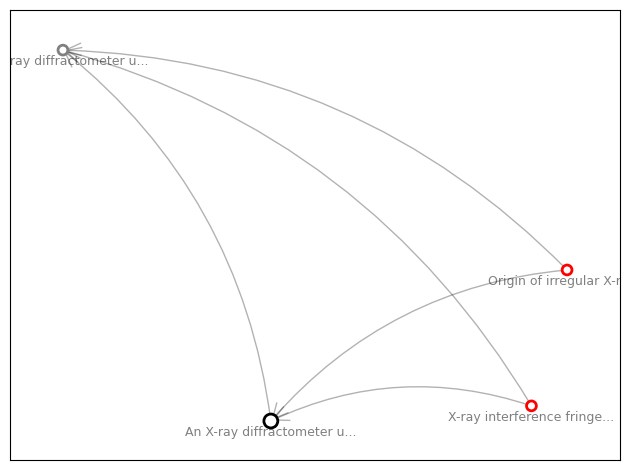

,title,publication_date,unix_time,date_diff,type,color,ypos,xpos,size
2149564907,An X-ray diffractometer using mirage diffraction,2014-07-19,1405695600,-16848000,-1.0,grey,62.959710,-51.68480,50
2127548443,An X-ray diffractometer using mirage diffracti...,2015-01-30,1422543600,0,0.0,black,0.000000,0.00000,100
2979336971,X-ray interference fringes from a weakly bent ...,2019-10-07,1570374000,147830400,1.0,red,2.566834,64.78304,50
4288080835,Origin of irregular X-ray mirage fringes from ...,2022-07-28,1658934000,236390400,1.0,red,25.638467,73.63904,50


In [7]:
draw_network(2127548443)

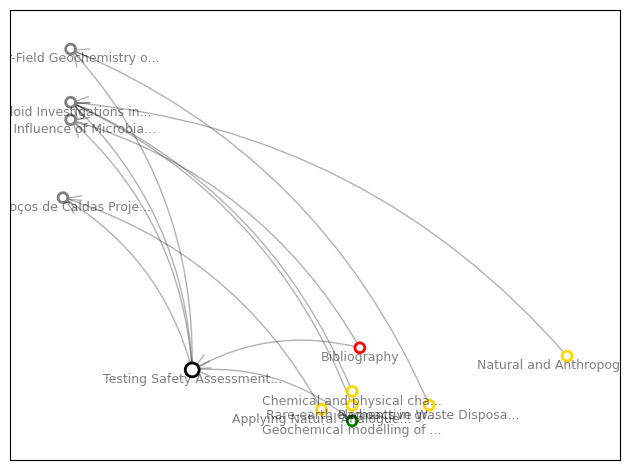

,title,publication_date,unix_time,date_diff,type,color,ypos,xpos,size
654852,The Poços de Caldas Project Feasibility Study:...,1987-01-01,536425200,-31536000,-1.0,grey,34.889160,-53.15360,50
2328928751,Colloid Investigations in the ‘Pocos De Caldas...,1988-01-01,567961200,0,-1.0,grey,54.222657,-50.00000,50
2101364943,The Influence of Microbial Activity on the Mov...,1988-01-01,567961200,0,-1.0,grey,50.673155,-50.00000,50
2119926751,Near-Field Geochemistry of Vitrified HLW in a ...,1988-01-01,567961200,0,-1.0,grey,64.986315,-50.00000,50
2170866237,Testing Safety Assessment Models Using Natural...,1988-01-01,567961200,0,0.0,black,0.000000,0.00000,100
4245849422,Bibliography,1994-01-01,757350000,189388800,1.0,red,4.478317,68.93888,50
3021567156,Geochemical modelling of uranium redistributio...,1993-01-01,725814000,157852800,2.0,green,-10.348584,65.78528,50
4246769951,Applying Natural Analogues in Predictive Perfo...,1989-01-01,599583600,31622400,3.0,gold,-7.973345,53.16224,50
3022164924,Rare-earth elements in groundwaters from the O...,1993-01-01,725814000,157852800,3.0,gold,-7.188289,65.78528,50
3021057528,Chemical and physical characterization of susp...,1993-01-01,725814000,157852800,3.0,gold,-4.354260,65.78528,50


In [8]:
draw_network(2170866237)

## データの分布

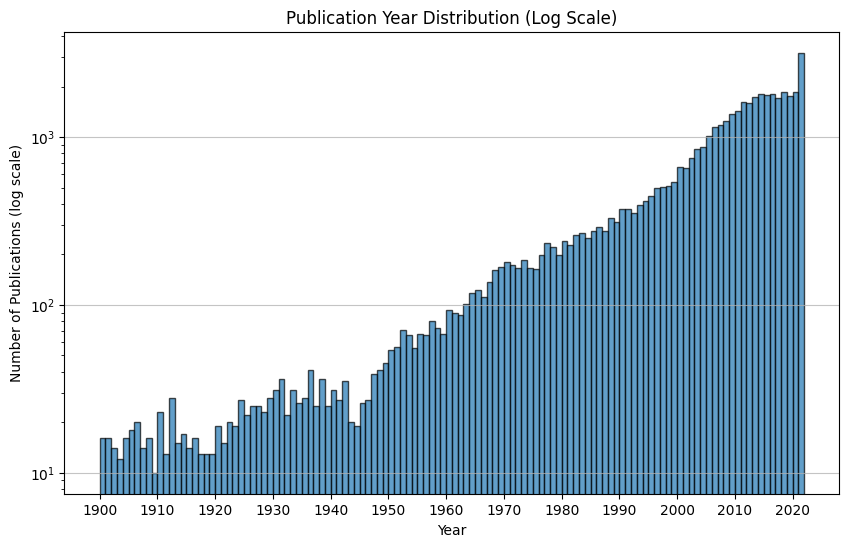

In [9]:
# works_df['Year']のヒストグラムの作成
plt.figure(figsize=(10, 6))
plt.hist(works_df['Year'], bins=range(1900, 2023), edgecolor='black', alpha=0.7, log=True)
plt.title("Publication Year Distribution (Log Scale)")
plt.xlabel("Year")
plt.ylabel("Number of Publications (log scale)")
plt.xticks(range(1900, 2023, 10))
plt.grid(axis='y', alpha=0.75)

# ヒストグラムの表示
plt.show()

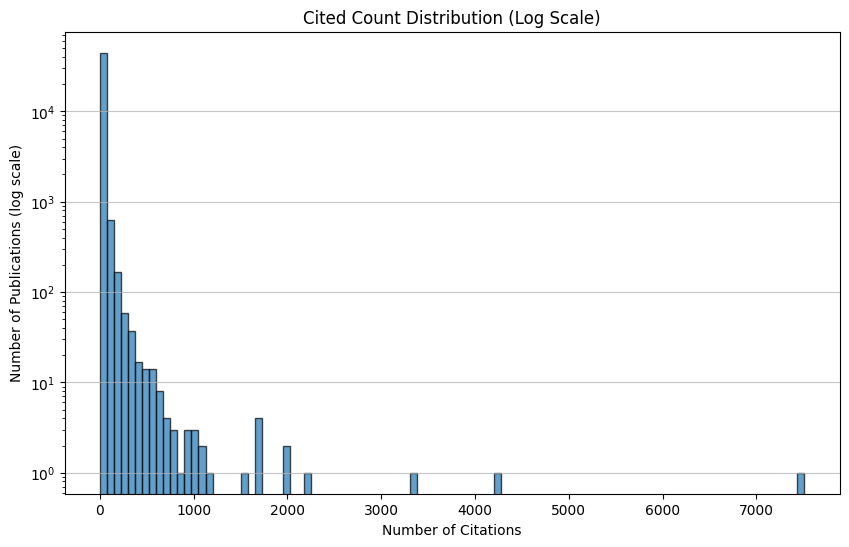

In [10]:
# works_df['NumberCitations']のヒストグラムの作成
plt.figure(figsize=(10, 6))
plt.hist(works_df['NumberCitations'], bins=100, edgecolor='black', alpha=0.7, log=True)
plt.title("Cited Count Distribution (Log Scale)")
plt.xlabel("Number of Citations")
plt.ylabel("Number of Publications (log scale)")
plt.grid(axis='y', alpha=0.75)

# ヒストグラムの表示
plt.show()

In [11]:
# 7min
def citation_groupby(df_citation):
    '''source,targetのDataFrameを引用先，引用元ごとにgroupby
    
    input: source,targetをcolumnにもつedgeのDataFrame

    index: eid
    source: indexが引用先となる論文群(sourceが新しい)
    target: indexが引用元となる論文群(targetが古い)
    '''
    
    citations_source_gp = df_citation.groupby('source').agg(list)
    citations_target_gp = df_citation.groupby('target').agg(list)
    df_citation_gp = pd.concat([citations_source_gp,citations_target_gp],axis = 1)
    return df_citation_gp

citations_gb = citation_groupby(citations_df)
citations_gb

,target,source
285,"[2042492557, 2127278384, 2136596860, 259957213...",NaN
417,"[1527311855, 1983741276, 2053120142, 208064788...",NaN
662,[2064918098],NaN
763,"[117192379, 134541578, 1526091749, 1965079780,...",NaN
1091,"[2018037215, 2339183141]",NaN
...,...,...
4386280481,NaN,[4388483438]
4386419348,NaN,"[4387365856, 4387903145]"
4386637234,NaN,"[3180041995, 3082985568, 3086726274, 297062346..."
4387427222,NaN,[1977219467]


## Disruption Indexの計算

In [12]:
flatten2 = lambda l: [item for sublist in l if sublist == sublist for item in sublist]

def get_score(node):
    try:
        node_r = set(citations_gb.target.loc[node])
        node_r_c = set(flatten2([citations_gb.source.loc[x] for x in node_r])) - set([node])
        node_c = set(citations_gb.source.loc[node])
        allnodes = node_c | node_r_c
        cite_target = node_c - node_r_c
        cite_targetref = node_r_c - node_c
        cite_target_targetref_both = node_r_c & node_c
        score = (len(cite_target)*1 + len(cite_target_targetref_both)*-1 + len(cite_targetref)*0)/len(allnodes)
        return score
    except:
        return None

In [13]:
# 17min
eids = works_df.index

res = []
for n, eid in enumerate(eids):
    if n % 5000 == 0: print(f'{n} / {len(works_df)}')
    res.append(get_score(eid))
scores = pd.DataFrame([[eid,re] for eid,re in zip(eids,res)])

scores.index = scores[0]
scores['team_size'] = scores[0].map(works_df['AuthorCount'])
scores = scores[~scores[1].isna()]
display(scores)

0 / 45535


5000 / 45535
10000 / 45535
15000 / 45535
20000 / 45535
25000 / 45535
30000 / 45535
35000 / 45535
40000 / 45535
45000 / 45535


,0,1,team_size
0,,,
2102983573,2102983573,0.000000,1.0
2170217184,2170217184,0.004845,10.0
2332852995,2332852995,0.048000,1.0
2027815162,2027815162,0.074074,1.0
1993059412,1993059412,0.001247,3.0
...,...,...,...
2110634737,2110634737,-0.006842,4.0
2076168890,2076168890,-0.003546,4.0
2468394869,2468394869,0.001149,5.0


## DIの分布

In [24]:
# team_sizeが1から10までのデータを抽出
scores_notna = scores[scores[1].notna() & scores['team_size'].notna()].drop(columns=0)
filtered_df = scores_notna[scores_notna['team_size'].between(1, 10)]

D = filtered_df[1].to_list()

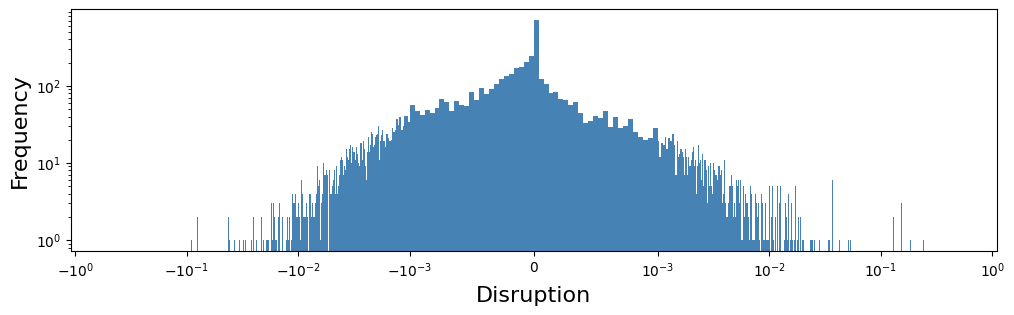

In [15]:
nbins=50000
fig = plt.figure(figsize=(10, 3),facecolor='white')
ax = fig.add_subplot(111)
#
N, bins, patches = ax.hist(D, bins=nbins,edgecolor='white', linewidth=0)
LN=np.log(max(N))


# Find fractions of small natural denominator and make them less distractive
delta=bins[1]-bins[0]
peaks=set([j/i for i in range(1,100) for j in range(1,i)]+\
[-j/i for i in range(1,100) for j in range(1,i)]) 
ys=dict((i,(patches[i-1]._height+patches[i+1]._height)*0.5) \
        for i in range(1,len(N)-2)) #smooth color

for i,z in zip(range(0,nbins),bins):
    if patches[i]._height>0: # only plot patches with values
        r=(np.log(patches[i]._height)/LN)**5 # transparency scales to y values
        for p in peaks:
            if z<p<z+delta and 0<i<len(N):
                r=(np.log(ys[i]+1)/LN)**5 # disruption fraction
        patches[i].set_alpha(1)
        patches[i].set_facecolor(color='SteelBlue')

#
plt.yscale('log')
plt.xscale('symlog',linthresh=0.001)
plt.tight_layout()
plt.xlabel('Disruption',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
#plt.savefig(path+'Fig1b.pdf')
plt.show()

## チームサイズとの関係

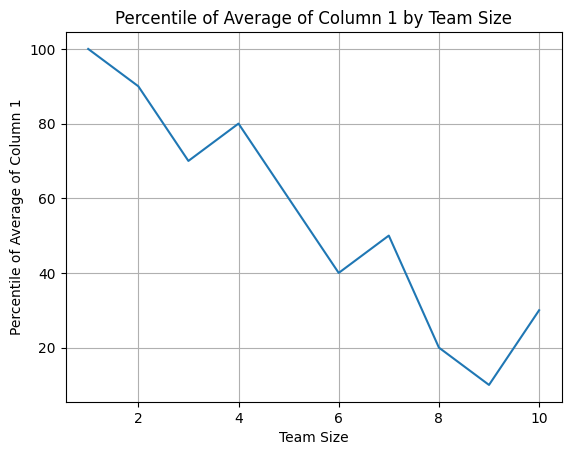

In [16]:
# team_sizeごとにグループ化し、1というカラムの平均値を計算
grouped_df = filtered_df.groupby('team_size').mean()

# 全体の平均値のパーセンタイルを計算
percentiles = grouped_df.rank(pct=True) * 100

# グラフの描画
plt.plot(percentiles.index, percentiles[1])
plt.xlabel('Team Size')
plt.ylabel('Percentile of Average of Column 1')
plt.title('Percentile of Average of Column 1 by Team Size')
plt.grid(True)
plt.show()


### 被引用数で分割した場合

In [18]:
from scipy import stats
import matplotlib.cm as cm
from collections import defaultdict
import sys

def flushPrint(d):
    sys.stdout.write('\r')
    sys.stdout.write(d)
    sys.stdout.flush()

teamsize,impact,disruption,referenceAge, referencePopularity = np.array(W).T
DisruptionPaper=random.sample(list(disruption),10000)

DisImpact=defaultdict(lambda:defaultdict(lambda:[]))
n=0
for teamsize,impact,disruption,referenceAge, referencePopularity in W:
    n+=1
    if n%100000==0:
        flushPrint(str(n/100000))
    if 1<=teamsize<=10 and impact>0:
        if impact<=1:
            ilevel=1
        if 1<impact<10:
            ilevel=2
        if 10<=impact<24:
            ilevel=3           
        if 24<=impact<53:
            ilevel=4           
        if 53<=impact<84:
            ilevel=5
        if impact>=84:
            ilevel=6
        DisImpact[ilevel][teamsize].append(disruption)

disImpact={}
disImpact1={}
for ilevel in [1,2,3,4,5,6]:
    disImpact[ilevel]=sorted([(k,stats.percentileofscore(DisruptionPaper, np.mean(v)))\
                                   for k,v in DisImpact[ilevel].items()])
    disImpact1[ilevel]=sorted([(k,np.mean(v)) for k,v in DisImpact[ilevel].items()])

241.0

/tmp/ipykernel_2506929/392337156.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap1 = cm.get_cmap('summer_r',7)


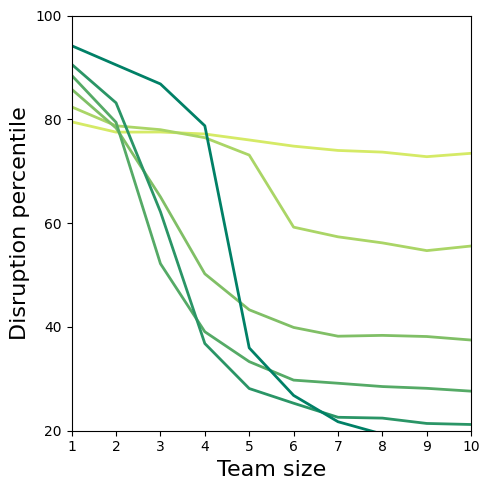

In [20]:
fig = plt.figure(figsize=(5,5),facecolor='white')
cmap1 = cm.get_cmap('summer_r',7)
ax = fig.add_subplot(111)
ip={1:'0-10',2:'10-50',3:'50-75',4:'75-90',5:'90-95',6:'95-100'}
for ilevel in [1,2,3,4,5,6]:
    x,y=np.array(disImpact[ilevel]).T
    plt.plot(x,y,color=cmap1(ilevel),linewidth=2,alpha=1,label=ip[ilevel])
ax.set_xlim(1,10)
ax.set_ylim(20,100)
ax.set_yticks([20,40,60,80,100])
plt.xlabel('Team size',fontsize=16)
plt.ylabel('Disruption percentile',fontsize=16)

plt.tight_layout()

## 高DI, 低DI, 中程度のDI論文を見てみる

In [21]:
filtered_df[filtered_df[1] == 1][:5].merge(works_df, left_index=True, right_index=True)

,1,team_size,JournalId,Year,NumberCitations,Title,Date,DocType,Doi,PMID,Volume,Issue,FirstPage,LastPage,IsRetracted,IsParaText,AuthorCount
1996985697,1.0,1.0,NaN,1903,1,CONSERVATIVE SURGERY OF THE TUBES AND OVARIES,1903-03-01,article,10.1111/j.1471-0528.1903.tb06905.x,NaN,NaN,NaN,NaN,NaN,False,False,1.0
826836893,1.0,1.0,NaN,2011,1,Zielone drogi - przyszłość dla zrównoważonej E...,2011-01-01,article,NaN,NaN,NaN,NaN,176,181,False,False,1.0
135020798,1.0,1.0,NaN,2007,1,Tax Laws Amendment (Simplified Superannuation)...,2007-01-01,article,NaN,NaN,NaN,NaN,NaN,NaN,False,False,1.0
2017636102,1.0,5.0,NaN,2014,1,Virtual factory for PCB and thick-film circuit...,2014-05-01,article,10.1109/isse.2014.6887644,NaN,NaN,NaN,NaN,NaN,False,False,5.0
1999665338,1.0,2.0,NaN,1993,1,Influence of grinding of a titanium powder on ...,1993-10-01,article,10.1007/bf00862762,NaN,NaN,NaN,NaN,NaN,False,False,2.0


In [22]:
filtered_df[filtered_df[1] < -0.6][:5].merge(works_df, left_index=True, right_index=True)

,1,team_size,JournalId,Year,NumberCitations,Title,Date,DocType,Doi,PMID,Volume,Issue,FirstPage,LastPage,IsRetracted,IsParaText,AuthorCount
2287754649,-0.666667,3.0,NaN,1971,6,Dèjerine-Sottas disease 1例,1971-12-01,article,NaN,NaN,6,4,415,418,False,False,3.0
2214504777,-0.714286,5.0,NaN,2010,7,수종의 산성용액이 교정용 브라켓의 전단결합강도에 미치는 영향,2010-09-01,article,NaN,NaN,37,3,243,250,False,False,5.0
2260739917,-0.666667,5.0,NaN,1996,8,국소 삽입 가능 물질의 Vancomycin 유리 농도의 실험적 측정,1996-04-01,article,NaN,NaN,31,2,395,400,False,False,5.0
2127548443,-1.000000,6.0,NaN,2015,2,An X-ray diffractometer using mirage diffracti...,2015-01-30,article,10.1107/s1600576714026028,26089753,48,1,312,312,False,False,6.0
1981100597,-1.000000,1.0,NaN,1929,1,Dentologia: The First Dental Didactic Poem in ...,1929-10-01,article,10.14219/jada.archive.1929.0279,NaN,16,10,1915,1923,False,False,1.0


In [23]:
filtered_df[filtered_df[1] == 0][:5].merge(works_df, left_index=True, right_index=True)

,1,team_size,JournalId,Year,NumberCitations,Title,Date,DocType,Doi,PMID,Volume,Issue,FirstPage,LastPage,IsRetracted,IsParaText,AuthorCount
2102983573,0.0,1.0,NaN,2002,3,Parallel one-sided Householder transformations...,2002-12-30,article,10.1109/empdp.1993.336400,NaN,NaN,NaN,NaN,NaN,False,False,1.0
2444544129,0.0,2.0,NaN,2016,8,An overview of oneM2M standard,2016-05-01,article,10.1109/siu.2016.7496087,NaN,NaN,NaN,NaN,NaN,False,False,2.0
2093697132,0.0,2.0,NaN,1988,2,Prediction of time variation in water and chlo...,1988-05-01,article,10.1016/0022-1694(88)90074-1,NaN,99,1-2,1,17,False,False,2.0
2589295893,0.0,1.0,NaN,2017,3,"Miscalculation of film thickness, friction and...",2017-06-01,article,10.1016/j.triboint.2017.02.022,NaN,NaN,NaN,NaN,NaN,False,False,1.0
2961852181,0.0,4.0,NaN,2019,6,IDA software for investigating asteroid dynami...,2019-10-01,article,10.1016/j.ascom.2019.100301,NaN,29,NaN,100301,100301,False,False,4.0


## Disruption Indexの利用 - 他の研究指標の関係

DIを用いて、研究の様々な変数と革新性との関連をみた研究を紹介する。ただし、一部の研究成果は#Disruption Indexの制約と限界の項で話すような点を考慮すると解釈が変わる可能性があり、結果は慎重に分析した上で受容する必要がある。

### チームサイエンス（共著）

小規模なチームほど革新性、大規模なチームほどインパクト（＝引用数）が大きい[L. Wu et al. 2019]

### 分野別の成果

放射線医学[Omar et al. 2022]、外科医学[Becerra et al. 2021]、眼科[Patal et al. 2022]、ほか

エネルギー安全保障分野[Y. Jiang et al. 2023]

ナノ科学[Kong et al. 2023]

### 引用数など、他の指標との関連

ノーベル賞受賞論文の平均DIは全論文でトップ2%のDIに相当する[]

ノーベル賞受賞論文を引用、被引用している論文は多くがDIが正 [A.J.Yang et al 2023]

Journal Impact Factorsの代替として [Y. Jiang et al. 2023]

### 時間的変化

第二次世界大戦以降、学術論文や特許全体で次第にDisruptionが下がり続けている - [Park et al. 2023]Disurption Index


## Disruption Indexの制約と限界

DIはNoveltyなどの他の指標と比べても、対象とする論文とその引用ネットワーク上での親子のみを使えば対象論文については出るため測りやすく使いやすい一方、いくつかの点で注意が必要であることが指摘されている。

一般に、指標は可操作化する概念以外のいかなるパラメターとも関連しないはずであり、その概念に関係のないパラメター影響している場合は、その指標がバイアスを持っていると言える。例えばDIにおいては、"disruption and consolidation"に関係のない変数がDIに影響している場合は、DIはバイアスのある指標だと言える。

DIによる分析の注意点については、[C. Leibel & L. Bornamnn 2023]による総説論文を参照すること。

- 引用データそのものに内在するバイアス - 引用データは完全ではなく、多くの欠損を含む。例えば、自然科学に比して社会学、人文学では出版物の総量に対して書誌データベースによってインデックスされた文献の量が遥かに少ないことが知られており[Bornmann 2020]、書籍や非英語文献の再録が十分でない。また、引用は多く修辞的であり[Tahamtan and Bornmann 2018]、着想に影響を与えた論文のみが引用されているとは限らず、引用のネットワークはノイズが大きい。例えば、[Ruan et al. 2021]の報告で社会科学、CSCCI（中国社会科学引用指数）に再録の論文ではDI=1の論文割合がそれぞれ3.1%, 27.5%と高く出る(経営学、工学、数学、神経科学、植物科学などの分野では2%未満)のは、書誌データベースに引用情報が登録されておらずNf = Nb = 0の場合を多く含むから。したがって古い文献についてもDIは正確に算出できない（多くの場合1になる）。したがって、社説、Letterm、書評、会議抄録などは雑誌論文との比較をしてはならない。

- 参照FPを引用していない論文によるDIへの影響に一貫性がない[Wu and Wu (2019)] - NrはConsolidatingな要素であるから、常にDisruptivenessを下げる方へ働くはずだが、Nf - Nbが負の時、Nrが増加するとDisruptivenessは増加する。

- 経時バイアス、安定するまで時間がかかる[Bornmann and Tekles (2019a)] - 論文がどの程度の期間にわたって新しい引用を獲得するかは論文間で大きく異なり、結果としてDisruptivenessの値が安定するまでも同様に時間がかかり、少なくとも出版から5年、長くて20年ほどが必要となる。

- FPが引用する文献の被引用数に依存するバイアス[Liu et al. (2023)] - FPが被引用数の高い論文を引用しているときには、その文献を引用している文献の数が増える傾向にあるので、DIは低下しやすい。一例として、Ke et al. (2015)の引用文献から有名なvan Raan (2004)(被引用数42)を削除するだけで、DIは-0.54から-0.18に増加する。

- FPが引用する文献数バイアス[Ruan et al. (2021)] - 同様の理由から、FPが引用している文献数が増えるほど、その文献を引用している文献の数が増える傾向にあるので、DIは低下しやすい。総説論文は原著論文に比べDIが低く出る。ただし、10件以上の引用文献がある論文に絞ると正の相関があるとの報告もある。

## 総論 - Disruption Indexの利用可能性

以上の制約を考慮した上でも、DIは利用の幅の広い指標である。

総論としては、DIを使用する際には以下の項目を揃える必要がある：文書形式（原著論文、社説、書評など）、言語、分野、出版からの経過年。また、引用文献データを十分に再録できていないと思われるデータとして、非常に古いデータ（一つの目安として、1960年以前の論文には注意が必要である）や非常に若いデータを削除すること。

また、引用数が少ない文献は非常に不安定な結果を生むため、引用数、被引用数が一定以上の文献を対象とすべきである。慣行としては10以上とすることが多い。

